In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -Uqq fastai
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()


In [3]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

In [5]:
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

In [6]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [7]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

### Inspect an image

In [8]:
im3_path = threes[1]
im3 = Image.open(im3_path) # Image class from Python Image Library PIL
im3

## Numpy array representation of pixels
Columns and Rows 4 to 10 (not included)

In [9]:
array(im3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

### Tensor representation

In [10]:
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

# Pixel representation
Display the top part of the number.

In [11]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


# Classification Attempt: Average of pixels
The idea is to have all images of 3s and 7s and take an average of each pixel between all the images. The images are 28x28 pixels, so we'll take an average of each of these in every image. For this we can use a stack to create a 3D tensor that stores images and pixel data.

First we store parse the images and store them in a python list

In [12]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

<Axes: >

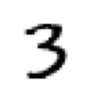

In [13]:
show_image(three_tensors[1])

Now we stack the python image tensors into one 3D tensor and we represent the pixel values (0-255) in a float between 0-1. We will have a single tensor with 6k images of 28 x 28 pixeles with values between 0-1.

In [14]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

## Jargon
Shape: Size of each axis of a tensor
Rank: Number of dimensions of a tensor

Don't confuse the term dimensions used in pytorch with spacial dimensions. A tensor of three elements can describe a point in 3D space, but it would still be a 1d tensor.

In [15]:
stacked_threes.ndim # Number of dimensions

3

## Mean of pixels
We take the mean aling axis 0, that stacks all of our images. These will be our average number visualizations.

<Axes: >

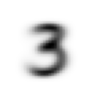

In [16]:
mean3 = stacked_threes.mean(0)
show_image(mean3)

<Axes: >

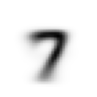

In [17]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

# Calculating the difference between number and ideal number
Idea: For each pixel calculate the difference, then average it between all pixels. The lowest difference should determine which number it is.

In [18]:
# My attempt solution of distances
print(f' mean difference 3 {tensor(mean3 - stacked_sevens[200]).mean()}')
print(f' mean difference 7 {tensor(mean7 - stacked_sevens[200]).mean()}')

# The intutition to calculate the differences is correct but I din't calculate it correctly so the numbers don't work

 mean difference 3 -0.031579095870256424
 mean difference 7 -0.05858154594898224


## Fast AI solution
### Loss function: Mean of Squares of differences
Scientists use the mean of the absolute values of differences to calculate difference or the mean of the square of the differences (Which makes it positive)

<Axes: >

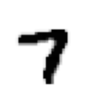

In [19]:
im7 = stacked_sevens[200]
show_image(im7)

In [20]:
dist_3_abs = (im7 - mean3).abs().mean()
dist_3_sqr = ((im7 - mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1840), tensor(0.3257))

In [21]:
dist_7_abs = (im7 - mean7).abs().mean() # l1_loss
dist_7_sqr = ((im7 - mean7)**2).mean().sqrt() # Square root Mean
dist_7_abs, dist_7_sqr

(tensor(0.1078), tensor(0.2168))

### l1_loss and mse_loss funtions

From the above, the difference is lower for mean7, so the prediction of this basic model is correct

Pytorch already provides both abs and sqrt loss functions in `torch.nn.functional` imported as `F`
`mean of absolute difference` => `l1_loss function`, L1 Norm, or `mean absoulut value`
`root mean square error (RMSE)` => `mse_loss` function or L2 Norm, or `mean squared error (MSE)`



In [22]:
F.l1_loss(im7.float(), mean7), F.mse_loss(im7, mean7).sqrt()

(tensor(0.1078), tensor(0.2168))

## Computing Metrics Using Broadcasting
To try any model we need a validation set. The MNIST data set of numbers already had a validation set separated.

In the code below we create an array of tensors out of the images in the validation path, we sort it and convert it into a tensor structure. Then we parse the elements to floats and normalize the pixel data by dividing by 255.

In [27]:
validation_3_tensors = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls().sorted()]).float()/255
validation_7_tensors = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls().sorted()]).float()/255
validation_3_tensors.shape, validation_7_tensors.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

### Distance function
A function to assess wether a number is closest to our ideal seven or three

<Axes: >

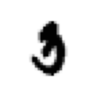

In [31]:
im3 = stacked_threes[200]
show_image(im3)

In [32]:
def mnist_distance(a, b):
    return (a-b).abs().mean((-1, -2))
mnist_distance(im3, mean3)

# mean(-1, -2) means that the mean is applied to the -1 and -2 axis of our tensor (last and one-before last), or where the vertical and horizontal data
# of the images is stored.

# For a list of tensors this will imply that the mean is not calculated for all images, but for each image separately.

tensor(0.1311)

### Broadcasting
We can use the same function but passing a thensor for `a` instead of a single image, and it will still work. We get a tensor of distances.

How?
When applying an operation to tensors of different rank PyTorch will "broadcast" or expand the tensor with the lowest rank to have the same size as the higher rank one.

In this case b, a single image will be broadcasted as a rank-2 tensor of images (an array of images).

- PyTorch doesn't copy the tensor, it just pretends it is. It doesn't allocate extra memory for it.
- It makes all these calculations on the GPU


In [33]:
mnist_distance(validation_3_tensors, mean3)

tensor([0.1280, 0.1623, 0.1242,  ..., 0.1508, 0.1263, 0.1260])

# Classification function
If the distance is smaller to mean3 then x is three.

In [35]:
def is_3(x):
    return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [36]:
is_3(im3), is_3(im3).float()

(tensor(True), tensor(1.))

We can apply the is_3 function to the whole tensore

In [37]:
is_3(validation_3_tensors)

tensor([ True,  True,  True,  ..., False,  True,  True])

# Accuracy of the predictions
We get an accuracy of over 90% for both numbers

In [39]:
accuracy_3s = is_3(validation_3_tensors).float().mean()
accuracy_7s = (1 - is_3(validation_7_tensors).float()).mean()
accuracy_3s, accuracy_7s

(tensor(0.9168), tensor(0.9854))